In [30]:
#!/usr/bin/env python
# coding: utf-8

# реализация по вейвлет-преобразованию

import pywt
import pylab
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from scipy import signal
from pylab import *


# функция извлечения данных из EDF
def data_extraxtion(file_name, chanel_num, start_sec, stop_sec):
    
    f = pyedflib.EdfReader(file_name)  
    n = f.signals_in_file  
    signal_labels = f.getSignalLabels() 
    sigbufs = np.zeros((n, f.getNSamples()[0]))

    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
        
    f.close()
    
    # частота дискретизации == 125 Гц
    x_data = [i for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]
    y_data = [sigbufs[chanel_num][i] for i in range(len(sigbufs[chanel_num]))][start_sec * 125 : stop_sec * 125]

    return x_data, y_data


# функция нахождения координат пиков и левого\правого концов из конкретного файла по конкретному каналу
def peaks_searching(file_name, chanel_num, start_sec, stop_sec):
    
    _, data_ = data_extraxtion(file_name, chanel_num, start_sec, stop_sec)
    
    st = 'sym2'        # тип преобразования
    lvl = 3           # уровень преобразования (кол-во применений к данному сигналу)
    
    data = pywt.downcoef('a', data_, st, mode = 'reflect', level = lvl)
    abs_max = max(data)
    trsh = 0.4
    
    dots_arr = []
    flag = True
    tmp = [0] * 5
    
    for i in range(int(stop_sec - start_sec)): #предполагается, что моргают уж никак не чаще чем раз в секунду

        #поиск max:
        max_ = max(data)
        max_ind =  np.where(data == max_)[0][0]

        #поиск min:
        min_ = min(data[max_ind : max_ind + 6])
        min_ind =  np.where(data == min_)[0][0]
        
        #если найденный максимум слишком мал
        if max_ < 0.3 * abs_max:
            flag = False

        # если не нашли новой точки
        if max_ind == tmp[1]:
            flag = False
           
        # если найденный паттерн не соответствует морганию 
        if abs(min_/max_) < trsh:
            flag = False

        #нахождение левого/правого концов пика:
        if flag and (min_ * max_ < 0) and (max_ind >= 6) and (min_ind <= len(data) - 6):

            for j in range(6):
                if data[max_ind - j] < 0.05 * max_:
                    left_ind = max_ind - j
                    break

            for j in range(6):
                if data[min_ind + j] > 0.05 * min_:
                    right_ind = min_ind + j
                    break

            #нахождение точки пересения нуля:
            zero_pos = max_ind + (min_ind - max_ind) * (max_ / (max_ - min_))

            #запись в датафрейм

            tmp = [left_ind, max_ind, zero_pos, min_ind, right_ind]
            dots_arr.append(tmp)

            #обнуляем в копии записи место, в котором нашли пик
            data[left_ind : right_ind] = 0
            
    
    columns_ = ['Left', 'Max', 'Zero', 'Min', 'Right'] 
    index_ = [i for i in range(len(dots_arr))]
    
    peaks_df = pd.DataFrame(dots_arr, index = index_, columns = columns_)
    peaks_df = peaks_df.sort_values('Left').reset_index(drop = True)

    #если точки повторяются
    for i in range(len(peaks_df)):
        if (i >= 1) and ((peaks_df['Right'][i - 1] == peaks_df['Right'][i]) or (peaks_df['Left'][i - 1] == peaks_df['Left'][i])):
            peaks_df = peaks_df.drop(index_[i:])
            break
            
    #если точки лежат слишком близко
    #for i in range(len(peaks_df)):
    #    if (i >= 1) and (peaks_df['Max'][i] - peaks_df['Max'][i - 1] <= 10):
    #       peaks_df = peaks_df.drop(index_[i])
    #       break
           
    peaks_df = peaks_df.sort_values('Left').reset_index(drop = True)
        
    return peaks_df

# Точка пересечения нуля
def zero_intersection(data, x_1, x_2):
    return x_1 + (x_2 - x_1) * ( data[x_1] / (data[x_1] - data[x_2]))


# выделение признаков из конкретного файла по конкретному каналу
def features_extraction(file_name, chanel_num, start_sec, stop_sec):
    
    _, data_ = data_extraxtion(file_name + '.edf', chanel_num, start_sec, stop_sec)
    
    st = 'sym2'        # тип преобразования
    lvl = 3           # уровень преобразования (кол-во применений к данному сигналу)
    data = pywt.downcoef('a', data_, st, mode = 'reflect', level = lvl)
    
    peaks_df = peaks_searching(file_name + '.edf', chanel_num, start_sec, stop_sec)
    len_df = len(peaks_df)
    
    columns_ = ['User', 'Max_A', 'Min_A', 'Max_pos', 'Min_pos', 'Left_tan','Center_tan', 'Right_tan', 'Left_s', 'Right_s']
    index_ = [i for i in range(len_df)]
    features_df = pd.DataFrame(index = index_, columns = columns_)

    for i in range(len_df):

        features_df['User'][i] = file_name.rstrip("_123456")

        features_df['Max_A'][i] = data[peaks_df['Max'][i]]
        features_df['Min_A'][i] = data[peaks_df['Min'][i]]

        features_df['Max_pos'][i] = peaks_df['Zero'][i] - peaks_df['Max'][i]
        features_df['Min_pos'][i] = peaks_df['Min'][i] - peaks_df['Zero'][i]
        
        features_df['Left_tan'][i] = (data[peaks_df['Max'][i]] - data[peaks_df['Left'][i]]) / (peaks_df['Max'][i] - peaks_df['Left'][i])
        features_df['Right_tan'][i] = (data[peaks_df['Right'][i]] - data[peaks_df['Min'][i]]) / (peaks_df['Right'][i] - peaks_df['Min'][i])
        features_df['Center_tan'][i] = (data[peaks_df['Min'][i]] - data[peaks_df['Max'][i]]) / (peaks_df['Min'][i] - peaks_df['Max'][i])
        
        true_pos_left = zero_intersection(data, peaks_df['Left'][i], peaks_df['Max'][i])
        true_pos_right = zero_intersection(data, peaks_df['Min'][i], peaks_df['Right'][i])
        
        features_df['Left_s'][i] = 0.5 * data[peaks_df['Max'][i]] * (peaks_df['Zero'][i] - true_pos_left)
        features_df['Right_s'][i] = 0.5 * data[peaks_df['Min'][i]] * (true_pos_right - peaks_df['Zero'][i])
    
    # преобразуем имена испытуемых

    names_arr = np.array(['Pavel', 'Elena', 'Mihail', 'Evgeny'])

    for i in range(len(features_df['User'])):
        features_df['User'][i] = np.where(names_arr == features_df['User'][i])[0][0] + 1

    return features_df


# нормализцаия
def normalize(df):
    
    len_df = len(df)
    mu = [sum(df[str_]) / len_df for str_ in list(df.columns.values)]
    sigma = [np.sqrt(sum((df[str_] - mu[np.where(df.columns.values == str_)[0][0]]) ** 2) / len_df)             for str_ in list(df.columns.values)]

    #print(len(mu), len(sigma))

    for str_ in list(df.columns.values):
        if str_ != 'User':
            for i in range(len(df[str_])):
                current_ind = np.where(df.columns.values == str_)[0][0]
                df[str_][i] = (df[str_][i]  - mu[current_ind]) / sigma[current_ind]         
    return df


# РАБОЧАЯ ЧАСТЬ
#names_arr = ['Pavel', 'Elena', 'Mihail', 'Evgeny']
names_arr = ['Pavel',  'Mihail']
str_arr = []

for str_1 in names_arr:
    for str_2 in ['_1', '_2', '_3', '_4', '_5', '_6']:
        try:
            _, _ =  data_extraxtion(str_1 + str_2 + '.edf', 4, 5, 15)
            str_arr.append(str_1 + str_2)
        except:
            pass

samples_num = len(str_arr)
chanel_num_arr = [3, 4]
start_sec = 5
stop_sec = 55

# предобработка + выделение признаков
features_df = pd.concat([features_extraction('Pavel_1', i, start_sec, stop_sec) for i in range(3, 5)]).reset_index(drop = True)

for i in range(2, samples_num * len(chanel_num_arr)):
        
    df_curr = features_extraction(str_arr[i // 2], chanel_num_arr[i % 2], start_sec, stop_sec)
    features_df = pd.concat([features_df, df_curr]).reset_index(drop = True)
            
features_df = features_df.sample(frac = 1).reset_index(drop = True)
features_df = normalize(features_df)


# преобразование типов
x_data = [[features_df[features_df.columns[i]][j] for j in range(len(features_df.index))] for i in range(1, len(features_df.columns))]
x_data = np.array(x_data).transpose()
y_data = list(features_df['User'])


# метод опорных векторов
#clf_svc_cv = SVC(kernel = 'linear', random_state = 777, C = 1e-1)
#res_svc = cross_val_score(clf_svc_cv, x_data, y_data, cv = 5)
#print('accuracy for SVC: ', np.mean(res_svc))


# случайный лес
#clf_rf_cv = RandomForestClassifier(n_estimators = 20, random_state = 42)
#res_rf = cross_val_score(clf_rf_cv, x_data, y_data, cv=5)
#print('accuracy for RF: ', np.mean(res_rf))


# К ближайших соседей
#clf_knn_cv = KNeighborsClassifier(n_neighbors = 6)
#res_knn = cross_val_score(clf_knn_cv, x_data, y_data, cv = 5)
#print('accuracy for kNN: ', np.mean(res_knn), '\n')


### ДЕФОЛТНАЯ кросс-валидация: разделение на train/test

trsh = 0.8
tmp = int(trsh * len(y_data))
y_data = np.array(y_data)

x_train = x_data[:tmp]
y_train = y_data[:tmp]

x_test = x_data[tmp:]
y_test = y_data[tmp:]

def_arr = []

# метод опорных векторов
clf_svc_def = SVC(kernel = 'linear', random_state = 777, C = 1)
clf_svc_def.fit(x_train, y_train)
y_pred = np.array(clf_svc_def.predict(x_test))
def_arr.append(accuracy_score(y_test, y_pred))
print('accuracy for SVC (Default): ', accuracy_score(y_test, y_pred))


# случайный лес
clf_rf_def = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
clf_rf_def.fit(x_train, y_train)
y_pred = np.array(clf_rf_def.predict(x_test))
def_arr.append(accuracy_score(y_test, y_pred))
print('accuracy for RF (Default): ', accuracy_score(y_pred, y_test))


# k ближайших соседей
clf_knn_def = KNeighborsClassifier(n_neighbors = 5)
clf_knn_def.fit(x_train, y_train)
y_pred = clf_knn_def.predict(x_test)
def_arr.append(accuracy_score(y_test, y_pred))
print('accuracy for kNN (Default): ', accuracy_score(y_pred, y_test), '\n')


### кросс-валидация KFold с 5тью фолдами
cv = KFold(n_splits = 5, random_state = 42, shuffle = True)
 
svc_res_arr = []
rf_res_arr = []
knn_res_arr = []

kf_arr = []

# метод split возвращает индексы для объектов train и test
for train_index, test_index in cv.split(y_data):
    
    # разделение на train/test
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # метод опорных векторов
    clf_svc_kf = SVC(kernel = 'linear', random_state = 777, C = 1)
    clf_svc_kf.fit(x_train, y_train)
    svc_res_arr.append(accuracy_score(y_test,  np.array(clf_svc_kf.predict(x_test))))
    
    # случайный лес
    clf_rf_kf = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
    clf_rf_kf.fit(x_train, y_train)
    rf_res_arr.append(accuracy_score(y_test,  np.array(clf_rf_kf.predict(x_test))))
    
    # k ближайших соседей
    clf_knn_kf = KNeighborsClassifier(n_neighbors = 5)
    clf_knn_kf.fit(x_train, y_train)
    knn_res_arr.append(accuracy_score(y_test,  np.array(clf_knn_kf.predict(x_test))))
    
print('accuracy for SVC (KFold): ', np.mean(svc_res_arr))
kf_arr.append(np.mean(svc_res_arr))

print('accuracy for RF (KFold): ', np.mean(rf_res_arr))
kf_arr.append(np.mean(rf_res_arr))

print('accuracy for kNN (KFold): ', np.mean(knn_res_arr), '\n')
kf_arr.append(np.mean(knn_res_arr))


### кросс-валидация ShuffleSplit с 5тью фолдами
cv = ShuffleSplit(n_splits=5, random_state = 42)
 
svc_res_arr = []
rf_res_arr = [] 
knn_res_arr = []

sp_arr = []

for train_index, test_index in cv.split(y_data):
    
    # разделение на train/test
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # метод опорных векторов
    clf_svc_sp = SVC(kernel = 'linear', random_state = 777, C = 1)
    clf_svc_sp.fit(x_train, y_train)
    svc_res_arr.append(accuracy_score(y_test,  np.array(clf_svc_sp.predict(x_test))))
    
    # случайный лес
    clf_rf_sp = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
    clf_rf_sp.fit(x_train, y_train)
    rf_res_arr.append(accuracy_score(y_test,  np.array(clf_rf_sp.predict(x_test))))
    
    # k ближайших соседей
    clf_knn_sp = KNeighborsClassifier(n_neighbors = 5)
    clf_knn_sp.fit(x_train, y_train)
    knn_res_arr.append(accuracy_score(y_test,  np.array(clf_knn_sp.predict(x_test))))
    
    
print('accuracy for SVC (ShuffleSplit): ', np.mean(svc_res_arr))
sp_arr.append(np.mean(svc_res_arr))

print('accuracy for RF (ShuffleSplit): ', np.mean(rf_res_arr))
sp_arr.append(np.mean(rf_res_arr))

print('accuracy for kNN (ShuffleSplit): ', np.mean(knn_res_arr), '\n')
sp_arr.append(np.mean(knn_res_arr))


accuracy for SVC (Default):  0.9411764705882353
accuracy for RF (Default):  0.9411764705882353
accuracy for kNN (Default):  0.9264705882352942 

accuracy for SVC (KFold):  0.9612379280070236
accuracy for RF (KFold):  0.9523705004389816
accuracy for kNN (KFold):  0.9435030728709395 

accuracy for SVC (ShuffleSplit):  0.9647058823529411
accuracy for RF (ShuffleSplit):  0.9529411764705882
accuracy for kNN (ShuffleSplit):  0.9529411764705882 



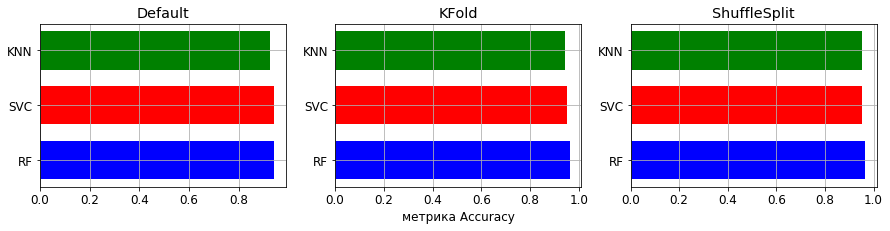

In [31]:
# графическое представление:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
 
mpl.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(15, 3))

subplot(1, 3, 1)
grid()
plt.title('Default')
x = np.array(["RF", "SVC", "KNN"])
y = np.array(def_arr)
 
plt.barh(x[0], y[0], height = 0.7, color = "blue")
plt.barh(x[1], y[1], height = 0.7, color = "red")
plt.barh(x[2], y[2], height = 0.7, color = "green")


subplot(1, 3, 2)
grid()
plt.title('KFold')
x = np.array(["RF", "SVC", "KNN"])
y = np.array(kf_arr)
 
plt.barh(x[0], y[0], height = 0.7, color = "blue")
plt.barh(x[1], y[1], height = 0.7, color = "red")
plt.barh(x[2], y[2], height = 0.7, color = "green")
    
plt.xlabel("метрика Accuracy")

subplot(1, 3, 3)
grid()
plt.title('ShuffleSplit')
x = np.array(["RF", "SVC", "KNN"])
y = np.array(sp_arr)


plt.barh(x[0], y[0], height = 0.7, color = "blue")
plt.barh(x[1], y[1], height = 0.7, color = "red")
plt.barh(x[2], y[2], height = 0.7, color = "green")

plt.show()

fig.savefig('barshoris.png')

In [32]:
from sklearn.metrics import precision_score

# ДЕФОЛТНАЯ кросс-валидация: разделение на train/test

# метод опорных векторов
clf_svc_def = SVC(kernel = 'linear', random_state = 777, C = 1)
clf_svc_def.fit(x_train, y_train)
y_pred = np.array(clf_svc_def.predict(x_test))
print('Precision for SVC (Default): ', precision_score(y_test, y_pred))


# случайный лес
clf_rf_def = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
clf_rf_def.fit(x_train, y_train)
y_pred = np.array(clf_rf_def.predict(x_test))
print('Precision for RF (Default): ', precision_score(y_pred, y_test))


# k ближайших соседей
clf_knn_def = KNeighborsClassifier(n_neighbors = 5)
clf_knn_def.fit(x_train, y_train)
y_pred = clf_knn_def.predict(x_test)
print('Precision for kNN (Default): ', precision_score(y_pred, y_test), '\n')


# кросс-валидация KFold с 5тью фолдами
cv = KFold(n_splits = 5, random_state = 42, shuffle = True)
 
svc_res_arr = []
rf_res_arr = []
knn_res_arr = []

# метод split возвращает индексы для объектов train и test
for train_index, test_index in cv.split(y_data):
    
    # разделение на train/test
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # метод опорных векторов
    clf_svc_kf = SVC(kernel = 'linear', random_state = 777, C = 1)
    clf_svc_kf.fit(x_train, y_train)
    svc_res_arr.append(precision_score(y_test,  np.array(clf_svc_kf.predict(x_test))))
    
    # случайный лес
    clf_rf_kf = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
    clf_rf_kf.fit(x_train, y_train)
    rf_res_arr.append(precision_score(y_test,  np.array(clf_rf_kf.predict(x_test))))
    
    # k ближайших соседей
    clf_knn_kf = KNeighborsClassifier(n_neighbors = 5)
    clf_knn_kf.fit(x_train, y_train)
    knn_res_arr.append(precision_score(y_test,  np.array(clf_knn_kf.predict(x_test))))
    
print('Precision for SVC (KFold): ', np.mean(svc_res_arr))
print('Precision for RF (KFold): ', np.mean(rf_res_arr))
print('Precision for kNN (KFold): ', np.mean(knn_res_arr), '\n')


# кросс-валидация ShuffleSplit с 5тью фолдами
cv = ShuffleSplit(n_splits=5, random_state = 42)
 
svc_res_arr = []
rf_res_arr = [] 
knn_res_arr = []

for train_index, test_index in cv.split(y_data):
    
    # разделение на train/test
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # метод опорных векторов
    clf_svc_sp = SVC(kernel = 'linear', random_state = 777, C = 1)
    clf_svc_sp.fit(x_train, y_train)
    svc_res_arr.append(precision_score(y_test,  np.array(clf_svc_sp.predict(x_test))))
    
    # случайный лес
    clf_rf_sp = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
    clf_rf_sp.fit(x_train, y_train)
    rf_res_arr.append(precision_score(y_test,  np.array(clf_rf_sp.predict(x_test))))
    
    # k ближайших соседей
    clf_knn_sp = KNeighborsClassifier(n_neighbors = 5)
    clf_knn_sp.fit(x_train, y_train)
    knn_res_arr.append(precision_score(y_test,  np.array(clf_knn_sp.predict(x_test))))
    
print('Precision for SVC (ShuffleSplit): ', np.mean(svc_res_arr))
print('Precision for RF (ShuffleSplit): ', np.mean(rf_res_arr))
print('Precision for kNN (ShuffleSplit): ', np.mean(knn_res_arr), '\n')

Precision for SVC (Default):  1.0
Precision for RF (Default):  0.9523809523809523
Precision for kNN (Default):  0.9523809523809523 

Precision for SVC (KFold):  0.975689223057644
Precision for RF (KFold):  0.9698462855073895
Precision for kNN (KFold):  0.9467522024133064 

Precision for SVC (ShuffleSplit):  0.9904761904761905
Precision for RF (ShuffleSplit):  0.9818181818181818
Precision for kNN (ShuffleSplit):  0.9726190476190476 



In [33]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# ДЕФОЛТНАЯ кросс-валидация: разделение на train/test

# метод опорных векторов
clf_svc_def = SVC(kernel = 'linear', random_state = 777, C = 1)
clf_svc_def.fit(x_train, y_train)
y_pred = np.array(clf_svc_def.predict(x_test))
print('recall_score for SVC (Default): ', recall_score(y_test, y_pred))


# случайный лес
clf_rf_def = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
clf_rf_def.fit(x_train, y_train)
y_pred = np.array(clf_rf_def.predict(x_test))
print('recall_score for RF (Default): ', recall_score(y_pred, y_test))


# k ближайших соседей
clf_knn_def = KNeighborsClassifier(n_neighbors = 5)
clf_knn_def.fit(x_train, y_train)
y_pred = clf_knn_def.predict(x_test)
print('recall_score for kNN (Default): ', recall_score(y_pred, y_test), '\n')


# кросс-валидация KFold с 5тью фолдами
cv = KFold(n_splits = 5, random_state = 42, shuffle = True)
 
svc_res_arr = []
rf_res_arr = []
knn_res_arr = []

# метод split возвращает индексы для объектов train и test
for train_index, test_index in cv.split(y_data):
    
    # разделение на train/test
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # метод опорных векторов
    clf_svc_kf = SVC(kernel = 'linear', random_state = 777, C = 1)
    clf_svc_kf.fit(x_train, y_train)
    svc_res_arr.append(recall_score(y_test,  np.array(clf_svc_kf.predict(x_test))))
    
    # случайный лес
    clf_rf_kf = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
    clf_rf_kf.fit(x_train, y_train)
    rf_res_arr.append(recall_score(y_test,  np.array(clf_rf_kf.predict(x_test))))
    
    # k ближайших соседей
    clf_knn_kf = KNeighborsClassifier(n_neighbors = 5)
    clf_knn_kf.fit(x_train, y_train)
    knn_res_arr.append(recall_score(y_test,  np.array(clf_knn_kf.predict(x_test))))
    
print('recall_score for SVC (KFold): ', np.mean(svc_res_arr))
print('recall_score for RF (KFold): ', np.mean(rf_res_arr))
print('recall_score for kNN (KFold): ', np.mean(knn_res_arr), '\n')


# кросс-валидация ShuffleSplit с 5тью фолдами
cv = ShuffleSplit(n_splits=5, random_state = 42)
 
svc_res_arr = []
rf_res_arr = [] 
knn_res_arr = []

for train_index, test_index in cv.split(y_data):
    
    # разделение на train/test
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # метод опорных векторов
    clf_svc_sp = SVC(kernel = 'linear', random_state = 777, C = 1)
    clf_svc_sp.fit(x_train, y_train)
    svc_res_arr.append(recall_score(y_test,  np.array(clf_svc_sp.predict(x_test))))
    
    # случайный лес
    clf_rf_sp = RandomForestClassifier(n_estimators = 18, max_depth = 5, random_state = 42)
    clf_rf_sp.fit(x_train, y_train)
    rf_res_arr.append(recall_score(y_test,  np.array(clf_rf_sp.predict(x_test))))
    
    # k ближайших соседей
    clf_knn_sp = KNeighborsClassifier(n_neighbors = 5)
    clf_knn_sp.fit(x_train, y_train)
    knn_res_arr.append(recall_score(y_test,  np.array(clf_knn_sp.predict(x_test))))
    
print('recall_score for SVC (ShuffleSplit): ', np.mean(svc_res_arr))
print('recall_score for RF (ShuffleSplit): ', np.mean(rf_res_arr))
print('recall_score for kNN (ShuffleSplit): ', np.mean(knn_res_arr), '\n')

recall_score for SVC (Default):  0.9523809523809523
recall_score for RF (Default):  1.0
recall_score for kNN (Default):  1.0 

recall_score for SVC (KFold):  0.9599807445442876
recall_score for RF (KFold):  0.950224646983312
recall_score for kNN (KFold):  0.9592105263157894 

recall_score for SVC (ShuffleSplit):  0.9544372294372294
recall_score for RF (ShuffleSplit):  0.9476277056277056
recall_score for kNN (ShuffleSplit):  0.9544372294372294 

